# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de pulsos muy cortos de duración τ y un periodo de escucha mayor Τ para luego leer el reflejo del mismo en alguna superficie. La distancia al objetivo se determina por el tiempo de ida y vuelta de la señal (en el caso estacionario) generando un Δ$t$, lo que nos permite utilizar la siguiente fómula:
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [1]:
import adi
import time
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import threading
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.34"
SamplingRate     = 6e6        # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1          # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 918e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = 0           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 6e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize     = 2**20-1

In [3]:
Uri2              = "ip:192.168.1.31"
SamplingRate2     = 6e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback2         = 0            # 0=Disabled, 1=Digital, 2=RF

TxLOFreq2         = 918e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten2          = 0          # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw2           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq2         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes2 = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain2   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw2           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize2     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:
  
$Max Range = \frac{c}{2}*PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [4]:
PRI = 0.001 #Se trata de un valor arbitrario, intervalo cada cuánto se repite el pulso (entre el inicio de un pulso y su antecesor)
PRF = 1/PRI #cantidad de pulsos por unidad de tiempo
potencia_señal = 1

pulses = 100 #cantidad de pulsos del radar

sample_f = SamplingRate
step = 1/SamplingRate #paso entre las muestras
f1 = 500e3
samples = pulses*int(PRI/step) # PRI/step cantidad de muestras que necesito para un PRI.

En esta porción de código calculamos la cantidad de $samples$ que vamos a utilizar, se obtiene de la división entre el intervalo de la repetición de pulsos y el paso entre las muestras, esto nos da la cantidad de muestras por pulso, luego, al multiplicarlo por la cantidad de pulsos del radar obtenemos la cantidad de muestras.

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi. Modulamos el tren de pulsos con la siguiente función senoidal

\begin{equation}
    Tx_I = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx_Q = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx = Tx_I + jTx_Q = \sin(2* \pi * f_1 * t) + j * \sin(2* \pi * f_1 * t)
\end{equation}


In [5]:
t = np.linspace(0,(samples-1)*step,samples) #Genera el array de valores de tiempo (600.000 valores separados cada <step> unidades de tiempo)
pulse_length = 0.0005 #[s] => 0.5 duración del pulso en segundos
Tx_I = 20*np.sin(2*np.pi*f1*t) + 20
Tx_Q = 20*np.sin(2*np.pi*f1*t + np.pi/2) + 20
zeros = np.zeros(len(t))  # arreglo completo
ones = np.ones(int(pulse_length*SamplingRate)) # señal continua de duracion pulse_length

for i in range(0,len(Tx_I),int(PRI*SamplingRate)):
      zeros[i:i+len(ones)] = ones #Cada un PRI, hacemos a la función zeros igual a 1 durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos)
        
#zeros[:int(pulse_length*SamplingRate)] = zeros[:int(pulse_length*SamplingRate)] * 20

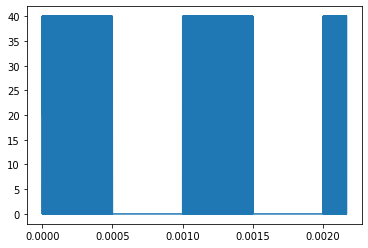

In [6]:
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = Tx_I + 1j * Tx_Q #señal completa

plt.plot(t[:13000],Tx[:13000])

In [7]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = True
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

In [8]:
#-----------------------------------SDR Configurations-------------------------------
sdr2             = adi.Pluto(Uri2)
sdr2.sample_rate = SamplingRate2
sdr2.loopback    = Loopback2
#Tx:
sdr2.tx_lo                 = int(TxLOFreq2)
sdr2.tx_hardwaregain_chan0 = TxAtten2
sdr2.tx_rf_bandwidth       = int(TxRfBw2)
sdr2.tx_buffer_size        = samples
sdr2.tx_cyclic_buffer      = False
# Rx:
sdr2.rx_lo                   = int(RxLOFreq2)
sdr2.gain_control_mode_chan0 = GainControlModes2
sdr2.rx_rf_bandwidth         = int(RxRfBw2)
sdr2.rx_cyclic_buffer        = False
sdr2.rx_buffer_size          = RxBufferSize2
sdr2.rx_enabled_channels = [0]

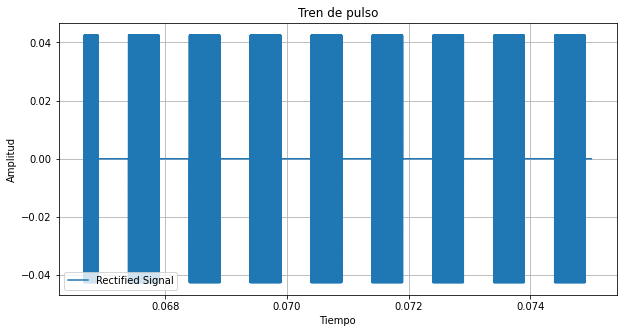

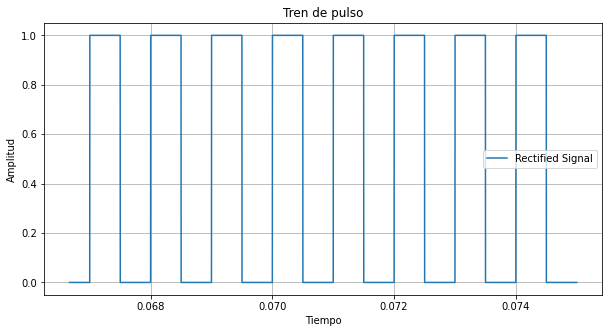

In [9]:
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()
sdr.tx(Tx * ((2**15-1)))
rxSignal = sdr.rx() / ((2**15-1))
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[400000:450000],rxSignal[400000:450000], label='Rectified Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[400000:450000],zeros[400000:450000], label='Rectified Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

Tramisión y Recepción

400662


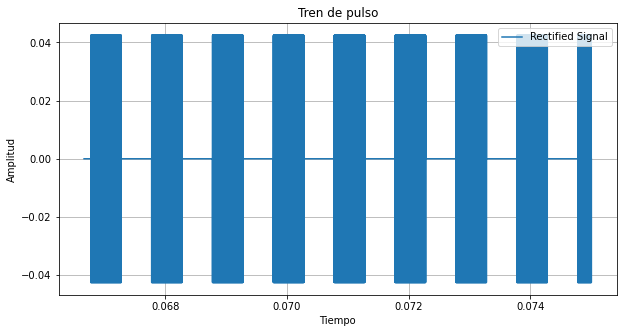

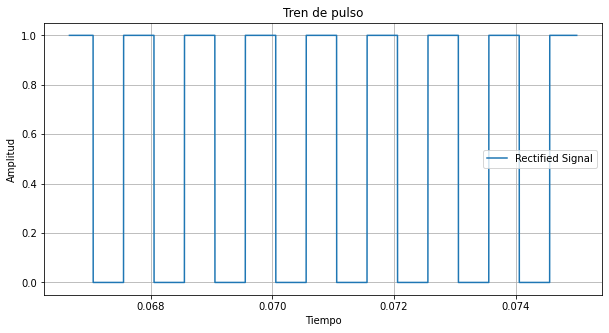

In [13]:
Loopback        = 1  
sdr.loopback    = Loopback
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()

# Función para la transmisión en un hilo
def transmitir():
        #global tiempoActual
        sdr.tx(Tx * ((2**15-1)))
        #tiempoActual = time.time()
        
# Función para la recepción en un hilo
def recibir():
        global rxSignal
        global tiempoActual
        rxSignal = sdr.rx() / ((2**15-1))
        tiempoActual = time.time()


# Crea los hilos
thread_tx = threading.Thread(target=transmitir)
thread_rx = threading.Thread(target=recibir)

# Inicia los hilos
thread_rx.start()
thread_tx.start()

# Espera a que los hilos terminen (esto no se ejecutará debido a los bucles infinitos)
thread_rx.join()
thread_tx.join()

#Loopback        = 0  
#sdr.loopback    = Loopback
trim = 0
trim = np.nonzero(rxSignal)[0][0]
print(trim)
zeros = np.roll(zeros, trim)
#zeros = np.roll(zeros, int((0.0005-0.00005)*6000000))
# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[400000:450000],rxSignal[400000:450000], label='Rectified Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[400000:450000],zeros[400000:450000], label='Rectified Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

In [11]:
#Loopback        = 0  
#sdr.loopback    = Loopback

stimationDiff = []
lenght = 1000
for l in range(lenght): 
    rxSignal = sdr.rx() / ((2**15-1))
    tiempoActual2 = time.time()
    tiempoViejo = tiempoActual
    tiempoActual = tiempoActual2
    tiempoDesp = tiempoActual - tiempoViejo

    print(tiempoDesp)
    desp =  int((tiempoDesp+pulse_length)*SamplingRate)

    zeros = np.roll(zeros, -desp)

    diff = (np.where(rxSignal == 0)[0][0] - np.where(zeros == 0)[0][0])

    if diff == 0:
        diff = (np.nonzero(rxSignal)[0][1] - np.nonzero(zeros)[0][0])

    print("Diff es:", abs(diff/SamplingRate))
    print(l)
    stimationDiff.append(abs(diff/SamplingRate))
    
    
    

0.6808485984802246
Diff es: 0.000176
0
0.21061921119689941
Diff es: 8.466666666666666e-05
1
0.20040583610534668
Diff es: 0.00039233333333333335
2
0.29958081245422363
Diff es: 0.000188
3
0.3478569984436035
Diff es: 2e-05
4
0.35126566886901855
Diff es: 0.00026116666666666665
5
0.3491783142089844
Diff es: 0.0002936666666666667
6
0.3483395576477051
Diff es: 3.9666666666666664e-05
7
0.3512845039367676
Diff es: 1.0833333333333334e-05
8
0.3484463691711426
Diff es: 0.0003088333333333333
9
0.3512604236602783
Diff es: 0.000195
10
0.34851837158203125
Diff es: 0.00014033333333333332
11
0.34833478927612305
Diff es: 0.00014566666666666667
12
0.35082054138183594
Diff es: 0.000375
13
0.3488750457763672
Diff es: 9.633333333333333e-05
14
0.3485734462738037
Diff es: 0.00035483333333333336
15
0.35005879402160645
Diff es: 0.000321
16
0.35242724418640137
Diff es: 0.00044083333333333333
17
0.34795212745666504
Diff es: 9e-06
18
0.3490731716156006
Diff es: 5.7333333333333336e-05
19
0.34462571144104004
Diff es:

0.3513343334197998
Diff es: 0.0004875
167
0.3483388423919678
Diff es: 0.0002976666666666667
168
0.3518106937408447
Diff es: 0.000338
169
0.3466789722442627
Diff es: 8.916666666666666e-05
170
0.35299134254455566
Diff es: 5.6e-05
171
0.3480801582336426
Diff es: 0.00011116666666666667
172
0.3510611057281494
Diff es: 0.00014766666666666666
173
0.3457508087158203
Diff es: 0.0001265
174
0.35192036628723145
Diff es: 0.00023066666666666667
175
0.34833550453186035
Diff es: 8e-05
176
0.3496277332305908
Diff es: 0.00031683333333333335
177
0.35135483741760254
Diff es: 1.3166666666666667e-05
178
0.3476572036743164
Diff es: 0.0003541666666666667
179
0.34997081756591797
Diff es: 0.00040833333333333336
180
0.352067232131958
Diff es: 0.000477
181
0.34855198860168457
Diff es: 0.0001615
182
0.34860897064208984
Diff es: 0.0004276666666666667
183
0.350888729095459
Diff es: 0.0002935
184
0.3476576805114746
Diff es: 0.0002425
185
0.34743475914001465
Diff es: 0.00020116666666666666
186
0.35063862800598145
Dif

0.35134077072143555
Diff es: 0.00025233333333333336
332
0.34903907775878906
Diff es: 9.566666666666667e-05
333
0.35053157806396484
Diff es: 0.00013883333333333334
334
0.3487823009490967
Diff es: 0.0001035
335
0.35088658332824707
Diff es: 0.00024183333333333332
336
0.3467254638671875
Diff es: 0.00017016666666666666
337
0.35324525833129883
Diff es: 0.0003206666666666667
338
0.34816646575927734
Diff es: 0.00017883333333333333
339
0.35027241706848145
Diff es: 5.5e-05
340
0.34987664222717285
Diff es: 7.933333333333333e-05
341
0.34876513481140137
Diff es: 0.00033916666666666665
342
0.34757280349731445
Diff es: 0.00020883333333333333
343
0.3511676788330078
Diff es: 0.000352
344
0.3496968746185303
Diff es: 2.4e-05
345
0.3479785919189453
Diff es: 2.2e-05
346
0.3513500690460205
Diff es: 0.00030316666666666665
347
0.344836950302124
Diff es: 0.0001155
348
0.3517160415649414
Diff es: 0.000333
349
0.3514747619628906
Diff es: 0.00025683333333333336
350
0.3492414951324463
Diff es: 0.000283666666666666

0.3472929000854492
Diff es: 0.000224
495
0.35123419761657715
Diff es: 1.4666666666666666e-05
496
0.34851884841918945
Diff es: 0.00020283333333333332
497
0.3509180545806885
Diff es: 0.00015766666666666666
498
0.34842944145202637
Diff es: 0.00022233333333333333
499
0.34863877296447754
Diff es: 0.00010833333333333333
500
0.3514997959136963
Diff es: 0.00013333333333333334
501
0.3507978916168213
Diff es: 0.00036033333333333333
502
0.3489255905151367
Diff es: 0.00045933333333333335
503
0.34845590591430664
Diff es: 2.8333333333333332e-05
504
0.34862232208251953
Diff es: 0.000485
505
0.3507089614868164
Diff es: 0.0002535
506
0.3484477996826172
Diff es: 0.00043566666666666667
507
0.3489053249359131
Diff es: 0.0003541666666666667
508
0.35124921798706055
Diff es: 0.0003863333333333333
509
0.34848761558532715
Diff es: 0.00024433333333333333
510
0.3509659767150879
Diff es: 0.00018533333333333333
511
0.34836339950561523
Diff es: 0.0002883333333333333
512
0.3485238552093506
Diff es: 2.316666666666666

0.3513634204864502
Diff es: 9.833333333333333e-05
657
0.34697413444519043
Diff es: 0.000211
658
0.35190248489379883
Diff es: 0.000222
659
0.3488898277282715
Diff es: 0.00016166666666666668
660
0.3510470390319824
Diff es: 0.00028533333333333335
661
0.34559011459350586
Diff es: 8.3e-05
662
0.35178112983703613
Diff es: 0.0003265
663
0.3485143184661865
Diff es: 6.3e-05
664
0.35118651390075684
Diff es: 0.00021366666666666667
665
0.34677958488464355
Diff es: 1.3666666666666667e-05
666
0.35062289237976074
Diff es: 0.000489
667
0.35083627700805664
Diff es: 0.00047516666666666665
668
0.3480062484741211
Diff es: 0.00043966666666666666
669
0.35158538818359375
Diff es: 3.15e-05
670
0.3487889766693115
Diff es: 0.00039033333333333335
671
0.35083484649658203
Diff es: 0.00026
672
0.34843873977661133
Diff es: 1.9666666666666666e-05
673
0.3471834659576416
Diff es: 0.0001785
674
0.3511362075805664
Diff es: 0.00028983333333333335
675
0.35001301765441895
Diff es: 0.0004888333333333333
676
0.348670244216918

0.3484475612640381
Diff es: 2.1666666666666667e-05
820
0.34969067573547363
Diff es: 2.666666666666667e-06
821
0.3479173183441162
Diff es: 0.00016566666666666666
822
0.35345959663391113
Diff es: 1.5166666666666667e-05
823
0.34735965728759766
Diff es: 0.00011633333333333333
824
0.3506283760070801
Diff es: 4.633333333333333e-05
825
0.34751391410827637
Diff es: 6.7e-05
826
0.3508720397949219
Diff es: 0.00025233333333333336
827
0.348771333694458
Diff es: 1.7666666666666668e-05
828
0.3485982418060303
Diff es: 0.000493
829
0.35126209259033203
Diff es: 0.00012083333333333333
830
0.3485684394836426
Diff es: 0.00039116666666666667
831
0.3508491516113281
Diff es: 0.00021566666666666666
832
0.3486363887786865
Diff es: 0.00039433333333333334
833
0.3484675884246826
Diff es: 0.00027016666666666666
834
0.35122084617614746
Diff es: 0.000345
835
0.3486361503601074
Diff es: 7.766666666666667e-05
836
0.3506436347961426
Diff es: 0.0002956666666666667
837
0.3450944423675537
Diff es: 5e-06
838
0.352399826049

0.34826087951660156
Diff es: 0.00016966666666666668
984
0.34892702102661133
Diff es: 0.00042616666666666665
985
0.35135388374328613
Diff es: 0.00012033333333333334
986
0.3484044075012207
Diff es: 7.216666666666667e-05
987
0.3485739231109619
Diff es: 7.1e-05
988
0.3519608974456787
Diff es: 0.00013333333333333334
989
0.3477663993835449
Diff es: 2.1666666666666667e-05
990
0.35124778747558594
Diff es: 0.00037766666666666667
991
0.34799671173095703
Diff es: 0.00034983333333333334
992
0.34930896759033203
Diff es: 0.0004476666666666667
993
0.35088133811950684
Diff es: 0.0004325
994
0.34848952293395996
Diff es: 4.4666666666666664e-05
995
0.35123658180236816
Diff es: 0.00016733333333333333
996
0.34830331802368164
Diff es: 0.000349
997
0.34878063201904297
Diff es: 0.00020166666666666667
998
0.3508446216583252
Diff es: 2.1333333333333335e-05
999


In [1]:

print("La media es: " + str(np.mean(stimationDiff)))
varianza = np.var(stimationDiff)

# Calcula la desviación estándar
desviacion_estandar = np.std(stimationDiff)

print(f'Varianza: {varianza}')
print(f'Desviación Estándar: {desviacion_estandar}')

plt.hist(stimationDiff, bins=len(stimationDiff), density=True, alpha=0.75, edgecolor='red')

# Personalizar el gráfico
plt.title('Diferencia en tiempo')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.xlim(0,max(stimationDiff))
# Ajustar la resolución
plt.figure(dpi=300)

# Mostrar el histograma
plt.show()

NameError: name 'np' is not defined